# Clasificación de grafos con redout Sum

In [32]:
import sys
sys.path.insert(0, '/Users/ahmedbegga/Desktop/TFG-Ahmed/SetXAI/')
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import *
from src.fspool import FSPool
from torch_scatter import scatter
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,DenseGraphConv, dense_mincut_pool
from torch_geometric.nn import global_mean_pool, global_max_pool,global_sort_pool
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
#torch.manual_seed(12345)
#print(f'Number of training graphs: {len(train_dataset)}')
#print(f'Number of test graphs: {len(test_dataset)}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [33]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(dataset[:150], batch_size=20, shuffle=True)
test_loader = DataLoader(dataset[150:], batch_size=20, shuffle=False)
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 766], x=[350, 7], edge_attr=[766, 4], y=[20], batch=[350], ptr=[21])

Step 2:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 774], x=[350, 7], edge_attr=[774, 4], y=[20], batch=[350], ptr=[21])

Step 3:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 792], x=[360, 7], edge_attr=[792, 4], y=[20], batch=[360], ptr=[21])

Step 4:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 756], x=[346, 7], edge_attr=[756, 4], y=[20], batch=[346], ptr=[21])

Step 5:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 768], x=[351, 7], edge_attr=[768, 4], y=[20], batch=[351], ptr=[21])

Step 6:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 866], x=[387, 7], edge_attr=[866, 4], y=[20], batch=[387], ptr=[21])

Step 7:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 800], x=[359, 7], edge_attr=[800, 4], y=[20], batch=[35

In [34]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=32):
        super(Net, self).__init__()

        # GCN Layer - MLP - Dense GCN Layer
        self.conv1 = GCNConv(in_channels, hidden_channels)
        num_of_centers =  16 # k
        # The degree of the node belonging to any of the centers
        self.pool1 = Linear(hidden_channels, num_of_centers) 
        self.conv2 = DenseGraphConv(hidden_channels, hidden_channels)
        # MLPs towards out 
        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, out_channels)
        self.weight = torch.nn.Parameter(torch.zeros(16,32))
        torch.nn.init.normal_(self.weight)
        # Input: Batch of 20 graphs, each node F=3 features 
        #        N1 + N2 + ... + N2 = 661
        # TSNE here?
        self.salidaConv = torch.zeros(0)
    def forward(self, x, edge_index, batch):    # x torch.Size([661, 3]),  data.batch  torch.Size([661])  
        # CONV1: Expand features from F=3 to F' = 32
        x = F.relu(self.conv1(x, edge_index))   # x torch.Size([661, 32]) 
        
        # Make all x_i of size N=MAX(N1,...,N20), e.g. N=40: 
        x, mask = to_dense_batch(x, batch)      # x torch.Size([20, N, 32]) ; mask torch.Size([20, N]) batch_size=20
        #print("x size", x.size())
        
        # Make all adjacencies of size NxN 
        adj = to_dense_adj(edge_index, batch)   # adj torch.Size([20, N, N])
        #print("adj_size", adj.size())
        
        # MLP of k=16 outputs s
        #print("adj_size", adj.size())
        s = self.pool1(x) # s torch.Size([20, N, k])
        #print("s_size", s.size())
        self.salidaConv = x
        # MINCUT_POOL
        # Call to dense_cut_mincut_pool to get coarsened x, adj and the losses: k=16
        x, adj, mincut_loss, ortho_loss = dense_mincut_pool(x, adj, s, mask) # x torch.Size([20, 16, 32]),  adj torch.Size([20, 16, 16])
        #print("Coarsened x and adj sizes:", x.size(), adj.size())

        # CONV2: Now on coarsened x and adj: 
        x = self.conv2(x, adj) #x torch.Size([20, 16, 32])
        #print("x_2 size", x.size())

        # Readout for each of the 20 graphs
        #x = x.mean(dim=1) # x torch.Size([20, 32])
        x = x.sum(dim=1) # x torch.Size([20, 32])
        #x, _ = x.sort(dim=1)
        #x = torch.einsum('nlc, lc -> nc', x, self.weight)
        #print(x.shape)
        #x =  x * self.weight
        #x = x.max(dim=1)[0]
        #x = x.max(dim=1)[0]
        #print("mean x_2 size", x.size())
        # Final MLP for graph classification: hidden channels = 32
        x = F.relu(self.lin1(x)) # x torch.Size([20, 32])
        #print("final x1 size", x.size())
        x = self.lin2(x) #x torch.Size([20, 2])
        #print("final x2 size", x.size())
        return F.log_softmax(x, dim=-1)

In [35]:
def train(epoch):
    model.train()
    loss_all = 0
    k = 0
    nG = 0
    for data in train_loader:
        data = data.to(device)
        #print(data.x.size(), data.edge_index.size(),data.batch.size(), k)
        data
        nG += data.num_graphs
        optimizer.zero_grad()
        out= model(data.x, data.edge_index, data.batch) # data.batch  torch.Size([783])
        loss = F.nll_loss(out, data.y.view(-1))
        loss.backward()
        loss_all += data.y.size(0) * loss.item()
        optimizer.step()
        k = k + 1
    #print("Training graphs per epoch", nG)
    return loss_all / len(train_dataset)


@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0

    for data in loader:
        data = data.to(device)
        pred = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(pred, data.y.view(-1))
        correct += pred.max(dim=1)[1].eq(data.y.view(-1)).sum().item()

    return loss, correct / len(loader.dataset)


best_val_loss = float('inf')
patience = start_patience = 50
resultados = []
for i in range(10):
    dataset = dataset.shuffle()
    train_dataset = dataset[:150]
    test_dataset = dataset[150:]
    train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Net(dataset.num_features, dataset.num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    for epoch in range(1, 50):
        train_loss = train(epoch)
        _, train_acc = test(train_loader)
        test_loss, test_acc = test(test_loader)
        print('Epoch: {:03d}, '
              'Train Loss: {:.3f}, Train Acc: {:.3f}, '
              'Test Loss: {:.3f}, Test Acc: {:.3f}'.format(epoch, train_loss,
                                                           train_acc,
                                                            test_loss,
                                                           test_acc))
    print(f'RUN:{i},Test Acc:{test_acc:.4f}')
    resultados.append(test_acc)

Epoch: 001, Train Loss: 0.626, Train Acc: 0.693, Test Loss: 0.700, Test Acc: 0.553
Epoch: 002, Train Loss: 0.553, Train Acc: 0.693, Test Loss: 0.673, Test Acc: 0.553
Epoch: 003, Train Loss: 0.512, Train Acc: 0.693, Test Loss: 0.589, Test Acc: 0.553
Epoch: 004, Train Loss: 0.500, Train Acc: 0.753, Test Loss: 0.559, Test Acc: 0.658
Epoch: 005, Train Loss: 0.471, Train Acc: 0.740, Test Loss: 0.547, Test Acc: 0.658
Epoch: 006, Train Loss: 0.449, Train Acc: 0.767, Test Loss: 0.524, Test Acc: 0.711
Epoch: 007, Train Loss: 0.432, Train Acc: 0.813, Test Loss: 0.488, Test Acc: 0.789
Epoch: 008, Train Loss: 0.418, Train Acc: 0.847, Test Loss: 0.463, Test Acc: 0.789
Epoch: 009, Train Loss: 0.404, Train Acc: 0.800, Test Loss: 0.475, Test Acc: 0.763
Epoch: 010, Train Loss: 0.390, Train Acc: 0.860, Test Loss: 0.434, Test Acc: 0.868
Epoch: 011, Train Loss: 0.375, Train Acc: 0.853, Test Loss: 0.444, Test Acc: 0.789
Epoch: 012, Train Loss: 0.373, Train Acc: 0.853, Test Loss: 0.417, Test Acc: 0.842
Epoc

Epoch: 005, Train Loss: 0.503, Train Acc: 0.780, Test Loss: 0.342, Test Acc: 0.763
Epoch: 006, Train Loss: 0.475, Train Acc: 0.800, Test Loss: 0.318, Test Acc: 0.868
Epoch: 007, Train Loss: 0.456, Train Acc: 0.813, Test Loss: 0.297, Test Acc: 0.868
Epoch: 008, Train Loss: 0.441, Train Acc: 0.827, Test Loss: 0.267, Test Acc: 0.868
Epoch: 009, Train Loss: 0.423, Train Acc: 0.820, Test Loss: 0.255, Test Acc: 0.868
Epoch: 010, Train Loss: 0.417, Train Acc: 0.827, Test Loss: 0.246, Test Acc: 0.868
Epoch: 011, Train Loss: 0.420, Train Acc: 0.827, Test Loss: 0.236, Test Acc: 0.868
Epoch: 012, Train Loss: 0.415, Train Acc: 0.827, Test Loss: 0.230, Test Acc: 0.868
Epoch: 013, Train Loss: 0.390, Train Acc: 0.860, Test Loss: 0.238, Test Acc: 0.868
Epoch: 014, Train Loss: 0.392, Train Acc: 0.820, Test Loss: 0.220, Test Acc: 0.895
Epoch: 015, Train Loss: 0.391, Train Acc: 0.847, Test Loss: 0.217, Test Acc: 0.895
Epoch: 016, Train Loss: 0.416, Train Acc: 0.853, Test Loss: 0.215, Test Acc: 0.895
Epoc

Epoch: 006, Train Loss: 0.435, Train Acc: 0.833, Test Loss: 0.363, Test Acc: 0.842
Epoch: 007, Train Loss: 0.415, Train Acc: 0.833, Test Loss: 0.332, Test Acc: 0.842
Epoch: 008, Train Loss: 0.423, Train Acc: 0.833, Test Loss: 0.315, Test Acc: 0.842
Epoch: 009, Train Loss: 0.396, Train Acc: 0.853, Test Loss: 0.323, Test Acc: 0.816
Epoch: 010, Train Loss: 0.390, Train Acc: 0.833, Test Loss: 0.286, Test Acc: 0.789
Epoch: 011, Train Loss: 0.373, Train Acc: 0.853, Test Loss: 0.296, Test Acc: 0.816
Epoch: 012, Train Loss: 0.380, Train Acc: 0.840, Test Loss: 0.270, Test Acc: 0.816
Epoch: 013, Train Loss: 0.367, Train Acc: 0.860, Test Loss: 0.266, Test Acc: 0.816
Epoch: 014, Train Loss: 0.362, Train Acc: 0.853, Test Loss: 0.249, Test Acc: 0.816
Epoch: 015, Train Loss: 0.359, Train Acc: 0.860, Test Loss: 0.244, Test Acc: 0.816
Epoch: 016, Train Loss: 0.357, Train Acc: 0.867, Test Loss: 0.241, Test Acc: 0.816
Epoch: 017, Train Loss: 0.359, Train Acc: 0.867, Test Loss: 0.236, Test Acc: 0.816
Epoc

Epoch: 010, Train Loss: 0.357, Train Acc: 0.860, Test Loss: 0.593, Test Acc: 0.842
Epoch: 011, Train Loss: 0.363, Train Acc: 0.867, Test Loss: 0.609, Test Acc: 0.842
Epoch: 012, Train Loss: 0.356, Train Acc: 0.860, Test Loss: 0.649, Test Acc: 0.842
Epoch: 013, Train Loss: 0.357, Train Acc: 0.860, Test Loss: 0.607, Test Acc: 0.842
Epoch: 014, Train Loss: 0.352, Train Acc: 0.873, Test Loss: 0.614, Test Acc: 0.842
Epoch: 015, Train Loss: 0.364, Train Acc: 0.860, Test Loss: 0.635, Test Acc: 0.842
Epoch: 016, Train Loss: 0.369, Train Acc: 0.860, Test Loss: 0.637, Test Acc: 0.842
Epoch: 017, Train Loss: 0.354, Train Acc: 0.873, Test Loss: 0.602, Test Acc: 0.842
Epoch: 018, Train Loss: 0.351, Train Acc: 0.867, Test Loss: 0.666, Test Acc: 0.816
Epoch: 019, Train Loss: 0.379, Train Acc: 0.873, Test Loss: 0.596, Test Acc: 0.842
Epoch: 020, Train Loss: 0.363, Train Acc: 0.867, Test Loss: 0.686, Test Acc: 0.816
Epoch: 021, Train Loss: 0.363, Train Acc: 0.867, Test Loss: 0.576, Test Acc: 0.842
Epoc

Epoch: 011, Train Loss: 0.394, Train Acc: 0.827, Test Loss: 0.217, Test Acc: 0.947
Epoch: 012, Train Loss: 0.400, Train Acc: 0.827, Test Loss: 0.211, Test Acc: 0.947
Epoch: 013, Train Loss: 0.393, Train Acc: 0.820, Test Loss: 0.218, Test Acc: 0.947
Epoch: 014, Train Loss: 0.411, Train Acc: 0.847, Test Loss: 0.202, Test Acc: 0.974
Epoch: 015, Train Loss: 0.397, Train Acc: 0.827, Test Loss: 0.209, Test Acc: 0.947
Epoch: 016, Train Loss: 0.393, Train Acc: 0.833, Test Loss: 0.202, Test Acc: 0.974
Epoch: 017, Train Loss: 0.389, Train Acc: 0.833, Test Loss: 0.195, Test Acc: 0.974
Epoch: 018, Train Loss: 0.390, Train Acc: 0.847, Test Loss: 0.195, Test Acc: 0.974
Epoch: 019, Train Loss: 0.384, Train Acc: 0.833, Test Loss: 0.197, Test Acc: 0.974
Epoch: 020, Train Loss: 0.387, Train Acc: 0.833, Test Loss: 0.198, Test Acc: 0.974
Epoch: 021, Train Loss: 0.388, Train Acc: 0.847, Test Loss: 0.191, Test Acc: 0.974
Epoch: 022, Train Loss: 0.384, Train Acc: 0.840, Test Loss: 0.191, Test Acc: 0.974
Epoc

In [36]:
res= torch.Tensor(resultados)
print(torch.mean(res))
print(torch.std(res))


tensor(0.8342)
tensor(0.0412)


In [37]:
test_loader = DataLoader(test_dataset[2:], batch_size=1, shuffle=False)
sample = next(iter(test_loader))
#sample.batch =torch.tensor(1)
print(sample)
print(sample.y)
out = model(sample.x,sample.edge_index, sample.batch)  # Perform a single forward pass.
pred = out.argmax(dim=1)  # Use the class with highest probability.
print(pred)
correct = 0
correct += int((pred[0] == sample[0].y).sum())  # Check against ground-truth labels.
print("Accuracy: ",(correct/1)*100)#Batch_size

DataBatch(edge_index=[2, 46], x=[22, 7], edge_attr=[46, 4], y=[1], batch=[22], ptr=[2])
tensor([0])
tensor([1])
Accuracy:  0.0


In [38]:
#https://www.geeksforgeeks.org/network-centrality-measures-in-a-graph-using-networkx-python/
#Nodos criticos
import networkx as nx
Conv_out= model.salidaConv
print(model.salidaConv.shape)
critical_nodes = Conv_out.argmax(0).unique().tolist()
#Pool_out = model.salidaPooling
print(Conv_out.shape)
#print(Pool_out.shape)
print(critical_nodes)
#print(Conv_out)
grafo_init = sample
A = to_networkx(grafo_init, to_undirected=True)
deg_centrality = list(nx.closeness_centrality(A))
print(torch.Tensor(deg_centrality).argsort(0).tolist())

torch.Size([1, 22, 32])
torch.Size([1, 22, 32])
[0]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


DataBatch(edge_index=[2, 46], x=[22, 7], edge_attr=[46, 4], y=[1], batch=[22], ptr=[2])


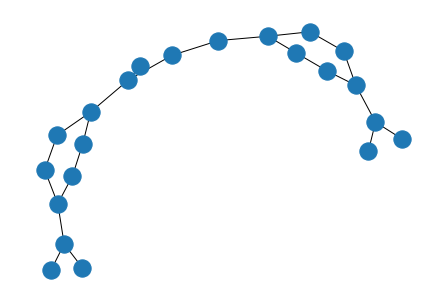

In [39]:

#loader =  DataLoader(dataset, batch_size=1, shuffle=False)
grafo_init = sample
print(grafo_init)
A = to_networkx(grafo_init, to_undirected=True)
l=[]
for a in A.nodes:
    l.append(a)
ed= []
for e in A.edges:
    ed.append(e)
import igraph as ig
import chart_studio.plotly
Edges= ed
G=ig.Graph(Edges, directed=False)
labels= l
#groups = A.node_attr_dict_factory
N = len(A.nodes)
#print(N)
layt=G.layout('kk', dim=3)
#print(layt)
Xn=[layt[k][0] for k in range(N)]# x-coordinates of nodes
Yn=[layt[k][1] for k in range(N)]# y-coordinates
Zn=[layt[k][2] for k in range(N)]# z-coordinates
Xe=[]
Ye=[]
Ze=[]
#print(Edges)
for e in Edges:
    Xe+=[layt[e[0]][0],layt[e[1]][0], None]# x-coordinates of edge ends
    Ye+=[layt[e[0]][1],layt[e[1]][1], None]
    Ze+=[layt[e[0]][2],layt[e[1]][2], None]
nx.draw(A)


node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(A.nodes()):
    #print(adjacencies,critical_nodes)
    if adjacencies in critical_nodes :
        node_adjacencies.append('rgb(256,0,0)')
    else:
        node_adjacencies.append('rgb(0,0,0)')
    #node_text.append('# of connections: '+str(len(adjacencies[1])))

In [40]:
from chart_studio import plotly
import plotly.graph_objs as go

trace1=go.Scatter3d(x=Xe,
               y=Ye,
               z=Ze,
               mode='lines',
               line=dict(color='rgb(125,125,125)', width=1),
               hoverinfo='none'
               )

trace2=go.Scatter3d(x=Xn,
               y=Yn,
               z=Zn,
               mode='markers',
               name='actors',
               marker=dict(symbol='circle',
                             size=6,
                             #color='#ff7f0e',
                             colorscale='Viridis',
                             line=dict(color='rgb(50,50,50)', width=0.5)
                             ),
               text=labels,
               hoverinfo='text'
               )
trace2.marker.color = node_adjacencies
#print(trace2)
axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

layout = go.Layout(
         title="3D graph visualization of Mutag dataset  by : Ahmed",
         width=1000,
         height=1000,
         showlegend=False,
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
     margin=dict(
        t=100
    ),
    hovermode='closest',)

In [41]:
import pandas as pd
import numpy as np
%matplotlib inline
import plotly.graph_objs as go
from  plotly.offline import plot
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected='true')
data=[trace1, trace2]
fig=go.Figure(data=data, layout=layout)

iplot(fig, filename='Les-Miserables')

In [42]:
dataset = TUDataset(root='data/TUDataset', name='PROTEINS')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: PROTEINS(1113):
Number of graphs: 1113
Number of features: 3
Number of classes: 2

Data(edge_index=[2, 162], x=[42, 3], y=[1])
Number of nodes: 42
Number of edges: 162
Average node degree: 3.86
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [43]:
#torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:890]
test_dataset = dataset[890:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 890
Number of test graphs: 223


In [44]:
from torch_geometric.loader import DataLoader



for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 712], x=[329, 7], edge_attr=[712, 4], y=[20], batch=[329], ptr=[21])

Step 2:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 870], x=[389, 7], edge_attr=[870, 4], y=[20], batch=[389], ptr=[21])

Step 3:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 784], x=[355, 7], edge_attr=[784, 4], y=[20], batch=[355], ptr=[21])

Step 4:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 792], x=[360, 7], edge_attr=[792, 4], y=[20], batch=[360], ptr=[21])

Step 5:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 754], x=[343, 7], edge_attr=[754, 4], y=[20], batch=[343], ptr=[21])

Step 6:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 842], x=[382, 7], edge_attr=[842, 4], y=[20], batch=[382], ptr=[21])

Step 7:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 762], x=[347, 7], edge_attr=[762, 4], y=[20], batch=[34

In [48]:
def train(epoch):
    model.train()
    loss_all = 0
    k = 0
    nG = 0
    for data in train_loader:
        data = data.to(device)
        #print(data.x.size(), data.edge_index.size(),data.batch.size(), k)
        data
        nG += data.num_graphs
        optimizer.zero_grad()
        out= model(data.x, data.edge_index, data.batch) # data.batch  torch.Size([783])
        loss = F.nll_loss(out, data.y.view(-1))
        loss.backward()
        loss_all += data.y.size(0) * loss.item()
        optimizer.step()
        k = k + 1
    #print("Training graphs per epoch", nG)
    return loss_all / len(train_dataset)


@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0

    for data in loader:
        data = data.to(device)
        pred = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(pred, data.y.view(-1))
        correct += pred.max(dim=1)[1].eq(data.y.view(-1)).sum().item()

    return loss, correct / len(loader.dataset)


best_val_loss = float('inf')
patience = start_patience = 50
for i in range(10):
    dataset = dataset.shuffle()
    train_dataset = dataset[:890]
    test_dataset = dataset[890:]
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Net(dataset.num_features, dataset.num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    for epoch in range(1, 50):
        train_loss = train(epoch)
        _, train_acc = test(train_loader)
        test_loss, test_acc = test(test_loader)
        print('Epoch: {:03d}, '
              'Train Loss: {:.3f}, Train Acc: {:.3f}, '
              'Test Loss: {:.3f}, Test Acc: {:.3f}'.format(epoch, train_loss,
                                                           train_acc,
                                                            test_loss,
                                                           test_acc))
    print(f'RUN:{i},Test Acc:{test_acc:.4f}')
    resultados.append(test_acc)

Epoch: 001, Train Loss: 0.593, Train Acc: 0.747, Test Loss: 0.651, Test Acc: 0.767
Epoch: 002, Train Loss: 0.545, Train Acc: 0.742, Test Loss: 0.576, Test Acc: 0.749
Epoch: 003, Train Loss: 0.529, Train Acc: 0.753, Test Loss: 0.579, Test Acc: 0.749
Epoch: 004, Train Loss: 0.521, Train Acc: 0.757, Test Loss: 0.557, Test Acc: 0.776
Epoch: 005, Train Loss: 0.516, Train Acc: 0.757, Test Loss: 0.585, Test Acc: 0.762
Epoch: 006, Train Loss: 0.514, Train Acc: 0.751, Test Loss: 0.559, Test Acc: 0.785
Epoch: 007, Train Loss: 0.514, Train Acc: 0.758, Test Loss: 0.567, Test Acc: 0.776
Epoch: 008, Train Loss: 0.513, Train Acc: 0.762, Test Loss: 0.552, Test Acc: 0.771
Epoch: 009, Train Loss: 0.503, Train Acc: 0.740, Test Loss: 0.576, Test Acc: 0.785
Epoch: 010, Train Loss: 0.506, Train Acc: 0.754, Test Loss: 0.557, Test Acc: 0.771
Epoch: 011, Train Loss: 0.501, Train Acc: 0.754, Test Loss: 0.564, Test Acc: 0.771
Epoch: 012, Train Loss: 0.500, Train Acc: 0.758, Test Loss: 0.549, Test Acc: 0.762
Epoc

Epoch: 002, Train Loss: 0.589, Train Acc: 0.710, Test Loss: 0.508, Test Acc: 0.785
Epoch: 003, Train Loss: 0.572, Train Acc: 0.735, Test Loss: 0.481, Test Acc: 0.771
Epoch: 004, Train Loss: 0.557, Train Acc: 0.735, Test Loss: 0.467, Test Acc: 0.789
Epoch: 005, Train Loss: 0.546, Train Acc: 0.739, Test Loss: 0.471, Test Acc: 0.798
Epoch: 006, Train Loss: 0.539, Train Acc: 0.734, Test Loss: 0.485, Test Acc: 0.803
Epoch: 007, Train Loss: 0.541, Train Acc: 0.739, Test Loss: 0.489, Test Acc: 0.794
Epoch: 008, Train Loss: 0.529, Train Acc: 0.743, Test Loss: 0.467, Test Acc: 0.803
Epoch: 009, Train Loss: 0.525, Train Acc: 0.730, Test Loss: 0.476, Test Acc: 0.789
Epoch: 010, Train Loss: 0.524, Train Acc: 0.744, Test Loss: 0.459, Test Acc: 0.803
Epoch: 011, Train Loss: 0.525, Train Acc: 0.727, Test Loss: 0.461, Test Acc: 0.789
Epoch: 012, Train Loss: 0.529, Train Acc: 0.744, Test Loss: 0.484, Test Acc: 0.776
Epoch: 013, Train Loss: 0.521, Train Acc: 0.739, Test Loss: 0.467, Test Acc: 0.789
Epoc

Epoch: 003, Train Loss: 0.550, Train Acc: 0.731, Test Loss: 0.499, Test Acc: 0.780
Epoch: 004, Train Loss: 0.537, Train Acc: 0.743, Test Loss: 0.505, Test Acc: 0.762
Epoch: 005, Train Loss: 0.523, Train Acc: 0.754, Test Loss: 0.474, Test Acc: 0.780
Epoch: 006, Train Loss: 0.516, Train Acc: 0.760, Test Loss: 0.465, Test Acc: 0.789
Epoch: 007, Train Loss: 0.509, Train Acc: 0.748, Test Loss: 0.469, Test Acc: 0.776
Epoch: 008, Train Loss: 0.510, Train Acc: 0.753, Test Loss: 0.454, Test Acc: 0.776
Epoch: 009, Train Loss: 0.506, Train Acc: 0.751, Test Loss: 0.456, Test Acc: 0.780
Epoch: 010, Train Loss: 0.500, Train Acc: 0.753, Test Loss: 0.441, Test Acc: 0.780
Epoch: 011, Train Loss: 0.500, Train Acc: 0.756, Test Loss: 0.441, Test Acc: 0.771
Epoch: 012, Train Loss: 0.508, Train Acc: 0.737, Test Loss: 0.469, Test Acc: 0.744
Epoch: 013, Train Loss: 0.510, Train Acc: 0.758, Test Loss: 0.422, Test Acc: 0.794
Epoch: 014, Train Loss: 0.495, Train Acc: 0.761, Test Loss: 0.437, Test Acc: 0.789
Epoc

Epoch: 004, Train Loss: 0.533, Train Acc: 0.755, Test Loss: 0.594, Test Acc: 0.749
Epoch: 005, Train Loss: 0.540, Train Acc: 0.751, Test Loss: 0.564, Test Acc: 0.731
Epoch: 006, Train Loss: 0.523, Train Acc: 0.755, Test Loss: 0.596, Test Acc: 0.758
Epoch: 007, Train Loss: 0.517, Train Acc: 0.758, Test Loss: 0.560, Test Acc: 0.744
Epoch: 008, Train Loss: 0.520, Train Acc: 0.752, Test Loss: 0.554, Test Acc: 0.762
Epoch: 009, Train Loss: 0.521, Train Acc: 0.751, Test Loss: 0.559, Test Acc: 0.744
Epoch: 010, Train Loss: 0.507, Train Acc: 0.757, Test Loss: 0.582, Test Acc: 0.749
Epoch: 011, Train Loss: 0.510, Train Acc: 0.762, Test Loss: 0.556, Test Acc: 0.753
Epoch: 012, Train Loss: 0.503, Train Acc: 0.767, Test Loss: 0.548, Test Acc: 0.744
Epoch: 013, Train Loss: 0.499, Train Acc: 0.758, Test Loss: 0.616, Test Acc: 0.740
Epoch: 014, Train Loss: 0.507, Train Acc: 0.758, Test Loss: 0.579, Test Acc: 0.753
Epoch: 015, Train Loss: 0.500, Train Acc: 0.769, Test Loss: 0.546, Test Acc: 0.749
Epoc

Epoch: 005, Train Loss: 0.521, Train Acc: 0.751, Test Loss: 0.675, Test Acc: 0.744
Epoch: 006, Train Loss: 0.519, Train Acc: 0.746, Test Loss: 0.699, Test Acc: 0.735
Epoch: 007, Train Loss: 0.508, Train Acc: 0.760, Test Loss: 0.687, Test Acc: 0.740
Epoch: 008, Train Loss: 0.503, Train Acc: 0.763, Test Loss: 0.683, Test Acc: 0.749
Epoch: 009, Train Loss: 0.504, Train Acc: 0.761, Test Loss: 0.683, Test Acc: 0.749
Epoch: 010, Train Loss: 0.500, Train Acc: 0.764, Test Loss: 0.696, Test Acc: 0.735
Epoch: 011, Train Loss: 0.506, Train Acc: 0.749, Test Loss: 0.702, Test Acc: 0.740
Epoch: 012, Train Loss: 0.500, Train Acc: 0.769, Test Loss: 0.681, Test Acc: 0.744
Epoch: 013, Train Loss: 0.496, Train Acc: 0.765, Test Loss: 0.694, Test Acc: 0.749
Epoch: 014, Train Loss: 0.494, Train Acc: 0.761, Test Loss: 0.699, Test Acc: 0.753
Epoch: 015, Train Loss: 0.493, Train Acc: 0.769, Test Loss: 0.694, Test Acc: 0.749
Epoch: 016, Train Loss: 0.490, Train Acc: 0.765, Test Loss: 0.691, Test Acc: 0.749
Epoc

In [49]:
res= torch.Tensor(resultados)
print(torch.mean(res))
print(torch.std(res))


tensor(0.7878)
tensor(0.0451)


In [47]:
test_loader = DataLoader(test_dataset[2:], batch_size=1, shuffle=False)
sample = next(iter(test_loader))
#sample.batch =torch.tensor(1)
print(sample)
print(sample.y)
out = model(sample.x,sample.edge_index, sample.batch)  # Perform a single forward pass.
pred = out.argmax(dim=1)  # Use the class with highest probability.
print(pred)
correct = 0
correct += int((pred[0] == sample[0].y).sum())  # Check against ground-truth labels.
print("Accuracy: ",(correct/1)*100)#Batch_size

DataBatch(edge_index=[2, 52], x=[16, 3], y=[1], batch=[16], ptr=[2])
tensor([1])
tensor([1])
Accuracy:  100.0


In [ ]:
import networkx as nx
from torch_geometric.utils import *
#loader =  DataLoader(dataset, batch_size=1, shuffle=False)
grafo_init = sample
print(grafo_init)
A = to_networkx(grafo_init, to_undirected=True)
l=[]
for a in A.nodes:
    l.append(a)
ed= []
for e in A.edges:
    ed.append(e)
import igraph as ig
import chart_studio.plotly
Edges= ed
G=ig.Graph(Edges, directed=False)
labels= l
#groups = A.node_attr_dict_factory
N = len(A.nodes)
print(N)
layt=G.layout('kk', dim=3)
print(layt)
Xn=[layt[k][0] for k in range(N)]# x-coordinates of nodes
Yn=[layt[k][1] for k in range(N)]# y-coordinates
Zn=[layt[k][2] for k in range(N)]# z-coordinates
Xe=[]
Ye=[]
Ze=[]
print(Edges)
for e in Edges:
    Xe+=[layt[e[0]][0],layt[e[1]][0], None]# x-coordinates of edge ends
    Ye+=[layt[e[0]][1],layt[e[1]][1], None]
    Ze+=[layt[e[0]][2],layt[e[1]][2], None]
nx.draw(A)
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(A.nodes()):
    #print(adjacencies,critical_nodes)
    if adjacencies in critical_nodes :
        node_adjacencies.append('rgb(256,0,0)')
    else:
        node_adjacencies.append('rgb(0,0,0)')
    #node_text.append('# of connections: '+str(len(adjacencies[1])))

In [ ]:
from chart_studio import plotly
import plotly.graph_objs as go

trace1=go.Scatter3d(x=Xe,
               y=Ye,
               z=Ze,
               mode='lines',
               line=dict(color='rgb(125,125,125)', width=1),
               hoverinfo='none'
               )

trace2=go.Scatter3d(x=Xn,
               y=Yn,
               z=Zn,
               mode='markers',
               name='actors',
               marker=dict(symbol='circle',
                             size=6,
                             #color='#ff7f0e',
                             colorscale='Viridis',
                             line=dict(color='rgb(50,50,50)', width=0.5)
                             ),
               text=labels,
               hoverinfo='text'
               )
trace2.marker.color = node_adjacencies
#print(trace2)
axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

layout = go.Layout(
         width=1000,
         height=1000,
         showlegend=False,
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
     margin=dict(
        t=100
    ),
    hovermode='closest',    )

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import plotly.graph_objs as go
from  plotly.offline import plot
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected='true')
data=[trace1, trace2]
fig=go.Figure(data=data, layout=layout)

iplot(fig, filename='Les-Miserables')